# **1. Import library**

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# **2. Load Dataset**

In [2]:
df = pd.read_excel('all_data.xlsx')

# **3. Data Wrangling**

## 3.1. Statistics Descriptive

In [3]:
# Ringkasan data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     295 non-null    int64  
 1   nama_tempat    295 non-null    object 
 2   rating         292 non-null    float64
 3   jumlah_ulasan  292 non-null    float64
 4   alamat         295 non-null    object 
 5   link           295 non-null    object 
 6   thumbnail      294 non-null    object 
 7   kategori       295 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 18.6+ KB


In [4]:
df.describe()

,Unnamed: 0,rating,jumlah_ulasan
count,295.00000,292.000000,292.000000
mean,147.00000,4.400000,1487.825342
std,85.30338,0.265806,2957.632440
min,0.00000,3.000000,1.000000
25%,73.50000,4.300000,132.500000
50%,147.00000,4.400000,440.000000
75%,220.50000,4.600000,1339.000000
max,294.00000,5.000000,24427.000000


## 3.2. Handling Missing Value

In [5]:
# Hapus baris dengan thumbnail kosong karena gambar penting untuk ditampilkan
df = df.dropna(subset=['rating', 'jumlah_ulasan', 'thumbnail'])

# Pastikan kolom numerik tidak ada NaN
df[['rating', 'jumlah_ulasan']] = df[['rating', 'jumlah_ulasan']].fillna(0)

# Buat kolom gabungan konten
df['content'] = df['kategori'] + ' ' + df['alamat']

<ipython-input-5-2bb9b2f2178f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['rating', 'jumlah_ulasan']] = df[['rating', 'jumlah_ulasan']].fillna(0)
<ipython-input-5-2bb9b2f2178f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['kategori'] + ' ' + df['alamat']


# **4. Exploratory Data Analysis (EDA)**

## 4.1. Distribusi Rating

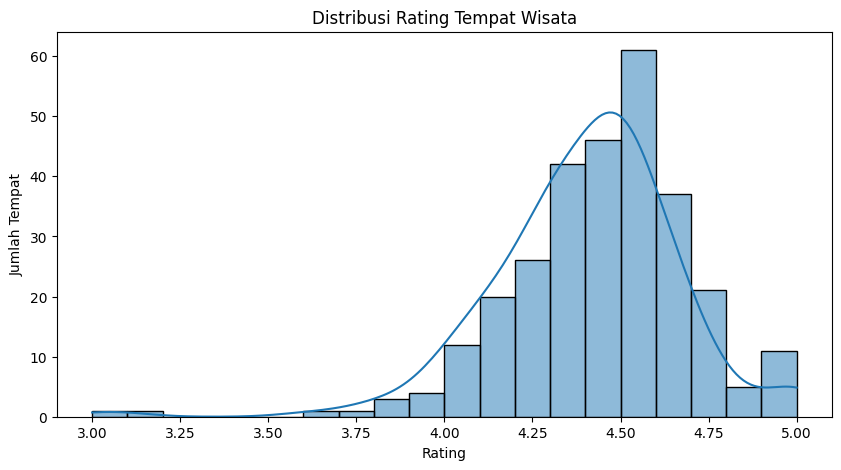

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Distribusi Rating Tempat Wisata')
plt.xlabel('Rating')
plt.ylabel('Jumlah Tempat')
plt.show()

## 4.2. Boxplot Jumlah Ulasan


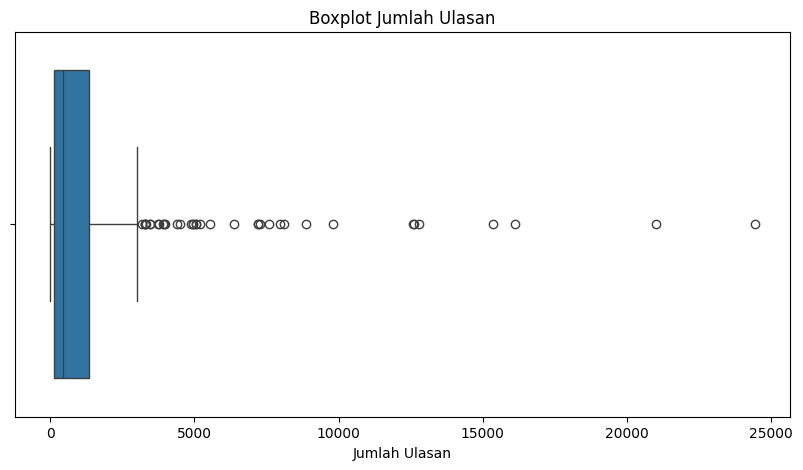

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['jumlah_ulasan'])
plt.title('Boxplot Jumlah Ulasan')
plt.xlabel('Jumlah Ulasan')
plt.show()

## 4.3. Korelasi antar fitur numerik

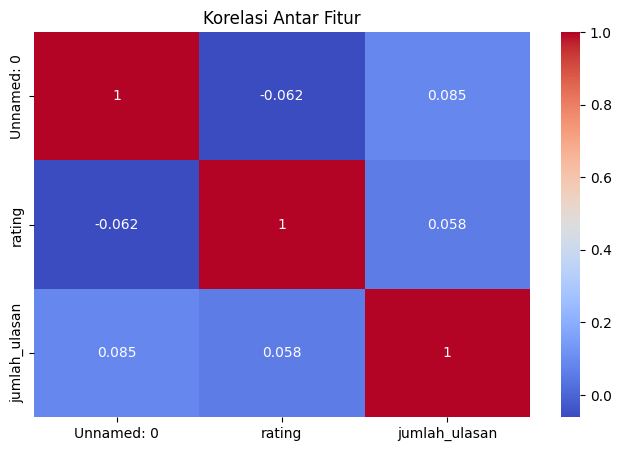

In [8]:
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Korelasi Antar Fitur')
plt.show()

# **5. Preprocessing**

In [9]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['content'])

# **6. Normalisasi**

In [10]:
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(df[['rating', 'jumlah_ulasan']])

# **7. Penggabungan Fitur**

In [11]:
item_features = hstack([tfidf_matrix, numerical_features])

# **9. Latih Model**

In [12]:
nbrs = NearestNeighbors(metric='cosine', algorithm='brute')
nbrs.fit(item_features)

NearestNeighbors(algorithm='brute', metric='cosine')

In [13]:
np.save('item_features.npy', item_features.toarray())
with open('cbf_nbrs.pkl', 'wb') as f:
    pickle.dump(nbrs, f)

print("✅ Model CBF berhasil dibuat dan disimpan.")

✅ Model CBF berhasil dibuat dan disimpan.


In [14]:
import json

# Konversi item_features ke list (pastikan .toarray() jika sparse matrix)
item_vectors = item_features.toarray().tolist()

# Simpan sebagai JSON
with open("item_features.json", "w") as f:
    json.dump(item_vectors, f)

# Simpan juga nama tempatnya
with open("item_names.json", "w") as f:
    json.dump(df['nama_tempat'].tolist(), f)